In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier

In [2]:
import cv2

## Read the image

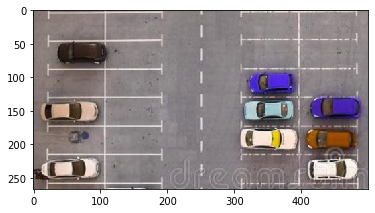

In [3]:
def getImage():
    image = cv2.imread('carparkfullcrop.jpg')
    (h,w,d) = image.shape

    r= 500.0/w
    w=500
    h=int(h*r)
    
    return cv2.resize(image,(w,h))
plt.imshow(getImage())

## Edge detection

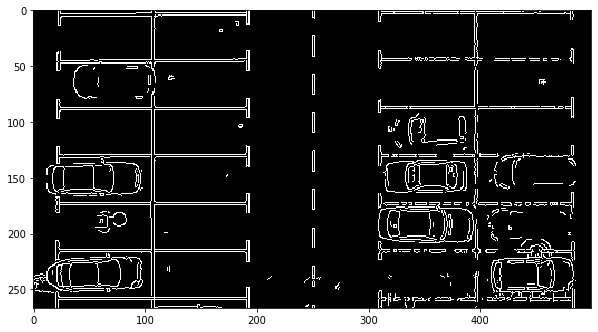

In [4]:
image = getImage()

lower = np.uint8([120,120,120])
upper = np.uint8([255,255,255])
white_mask = cv2.inRange(image,lower,upper)

white_mask = cv2.inRange(image,lower,upper)

plt.rcParams["figure.figsize"] = (10,10)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edged = cv2.Canny(gray,150,200)

plt.imshow(edged,cmap='gray')


## Hough transformation

In [5]:
lines = cv2.HoughLinesP(edged,rho=0.1,theta=np.pi/10,threshold=100,minLineLength=9,maxLineGap=4)

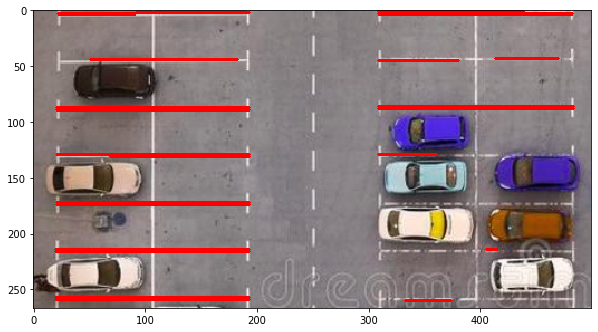

In [6]:
image=getImage()
goodLines = []
for line in lines:
    for x1,y1,x2,y2 in line:
        if (abs(y2-y1) <=1) and abs(x2-x1)>=0 and abs(x2-x1) <= 200:
            goodLines.append([x1,y1,x2,y2])
            cv2.line(image,(x1,y1),(x2,y2),(255,0,0),2)
plt.imshow(image)

## Find cluster of parking spaces

In [7]:
goodLines.sort(key = lambda line: line[0])

In [8]:

clusters = {0:[goodLines[0]]}
index = 0
distanceMax = 100

for line in range(len(goodLines)-1):
    distance = goodLines[line+1][0]-goodLines[line][0]
    if distance <= distanceMax:
        clusters[index].append(goodLines[line+1])
    else:
        index+=1
        clusters[index] = []
        clusters[index].append(goodLines[line+1])
    

In [9]:
rectCoords = {}
for index in clusters.keys():
    minLines = np.amin(np.array(clusters[index]),axis=0)
    maxLines = np.amax(np.array(clusters[index]),axis=0)
    rectCoord = [minLines[0],minLines[1],maxLines[2],maxLines[3]]
    rectCoords[index] = rectCoord

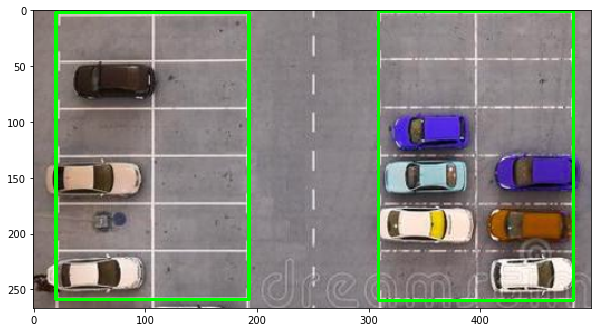

In [10]:
image = getImage()
for index in rectCoords.keys():
    cv2.rectangle(image,(rectCoords[index][0],rectCoords[index][1]),(rectCoords[index][2],rectCoords[index][3]),(0,255,0),2)
plt.imshow(image)  

## Find individual parking spaces

In [11]:
spaceNum = 6
spaceHeight = (rectCoords[0][3]-rectCoords[0][1])/spaceNum
spaceWidth  = (rectCoords[0][2]-rectCoords[0][0])/2.0

In [12]:
image = getImage()
for rectI in rectCoords:
    rect = rectCoords[rectI]
    x,y = rect[0],rect[1]
    for spaceH in range(spaceNum):
        cv2.line(image,(x,y+spaceH*int(spaceHeight)),(x+int(spaceWidth),y+spaceH*int(spaceHeight)),(255,0,0),2)
        cv2.line(image,(x+int(spaceWidth),y+spaceH*int(spaceHeight)),(x+2*int(spaceWidth),y+spaceH*int(spaceHeight)),(255,0,0),2)

        for w in range(3):
            cv2.line(image,(x+w*int(spaceWidth),y+spaceH*int(spaceHeight)),(x+w*int(spaceWidth),y+(spaceH+1)*int(spaceHeight)),(255,0,0),2)

    cv2.line(image,(x,y+(spaceH+1)*int(spaceHeight)),(x+int(spaceWidth),y+(spaceH+1)*int(spaceHeight)),(255,0,0),2)
    cv2.line(image,(x+int(spaceWidth),y+(spaceH+1)*int(spaceHeight)),(x+2*int(spaceWidth),y+(spaceH+1)*int(spaceHeight)),(255,0,0),2)
    pass

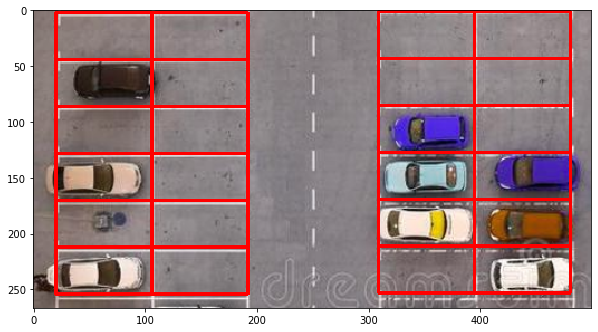

In [13]:
plt.imshow(image)

In [14]:
image = getImage()

spaceBoundsList = []
for rectI in rectCoords:
    rect = rectCoords[rectI]
    x,y = rect[0],rect[1]
    spaceHeight = int(spaceHeight)
    spaceWidth = int(spaceWidth)
    for spaceH in range(spaceNum):
        #print(spaceBoundsList)
        spaceBoundsList.append([x,y+spaceHeight*spaceH,x+spaceWidth,y+spaceHeight*(spaceH+1)])
        
        spaceBoundsList.append([x+spaceWidth,y+spaceHeight*spaceH,x+2*spaceWidth,y+spaceHeight*(spaceH+1)])
      



In [15]:
croppedSpaces = []
for spaceBound in spaceBoundsList:
    s = spaceBound
    im1 = image[s[1]:s[3],s[0]:s[2]]
    croppedSpaces.append(im1)
croppedSpaces = np.array(croppedSpaces)

print(croppedSpaces.shape)

(24, 42, 86, 3)


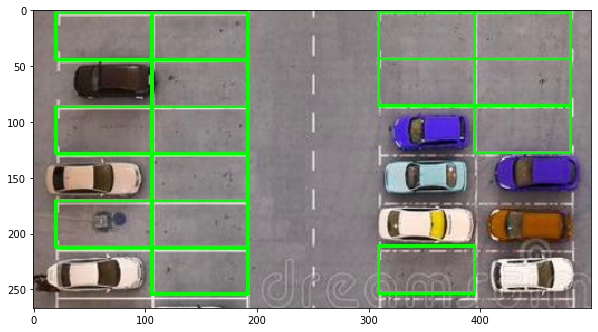

In [16]:
spaceMeans = []
labels = np.array([])
image=getImage()
spaceEdgeCount = np.array([])
for space in range(len(croppedSpaces)):
    
    edged = cv2.Canny(croppedSpaces[space],150,200)
    spaceEdgeCount = np.append(spaceEdgeCount,np.array([edged.sum()]))
    if edged.sum() < 85000:
        labels = np.append(labels,0)
        cv2.rectangle(image,(spaceBoundsList[space][0],spaceBoundsList[space][1]),(spaceBoundsList[space][2],spaceBoundsList[space][3]),(0,255,0),2)
    else:
        
        labels = np.append(labels,1)
plt.imshow(image)
